In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
path = ("C:/Users/Ong Jia Yi/Desktop/STUDY/Summer 2021"
        "/Rotman MMA Summer 2021 Datathon")

load = pd.read_csv(path + "/NWHL.csv")

In [3]:
load['Home Team Y/N'] = (load.Team == load.loc[:,'Home Team'])*1

In [4]:
def time_elapsed(dataframe):
    """Return game time elapsed in seconds based on period number"""
    period, clock = dataframe['Period'], dataframe['Clock']
    m, s = clock.split(':')
    seconds = int(m)*60 + int(s)
    
    if period == 4:
        elapsed = 5*60 - seconds
    else:
        elapsed = 20*60 - seconds
    return elapsed

In [5]:
load['Elapsed'] = load.apply(lambda x: time_elapsed(x), axis=1)

### DEFINITIONS
1) "outcomes" is defined to be the end of a sequence of prior events that are of interest.

## Function - prior_events

In [6]:
def prior_events(outcome_data):
    """Return a dataframe of the details of events that led to an outcome
    of interest.
    
    Arguments:
    outcome_data -- subset of the original Pandas DataFrame where
                    the outcome(s) of interest occur.Indexes of <outcome_data>
                    preserves that of the original dataframe.
    Returns:
    new_frame -- Pandas DataFrame containing info. on prior events.
    """
    new_frame = []
    for i in outcome_data.index:
        
        if i < window_len:
            continue

        new_row = []
        for j in range(1, window_len+1):
            last_event = load.loc[i-j, outcome_data.columns]
            last_event = np.array(last_event)
            new_row.append(last_event)
        new_row = np.concatenate(new_row)

        new_frame.append([new_row])
    
    new_frame = pd.DataFrame(np.concatenate(new_frame))
    colnames = ["{}_l{}".format(name, i) for i in range(1, window_len+1) \
                for name in outcome_data.columns]
    new_frame.columns = colnames
    
    return new_frame

## Function - encode_player

In [7]:
def encode_players(outcome_data, prior_events_data, all_players, window_len):
    """Encode the outcome player and prior event player(s) by their IDs,
    which are their order of appearance in the original dataset.
    
    Arguments:
    outcome_data -- subset of the original Pandas DataFrame where
                    the outcome(s) of interest occur.
    prior_events_data -- output from prior_events() function with 
                         the same <outcome_data> input.
    all_players -- a Numpy array of all player names in the original 
                   dataset (no repetition).
    window_len -- (int) the number of previous events to include.
    
    Returns:
    player_encoded -- a Pandas DataFrame of the IDs of the player associated
                      to the outcome and prior events.
    """
    outcome_player = outcome_data.loc[window_len:,'Player'].reset_index(drop=True)
    prior_players = prior_events_data.filter(regex="Player").reset_index(drop=True)

    merged = pd.concat([outcome_player, prior_players], ignore_index=True, axis=1)
    
    # plus one so ID starts at 1
    players_encoded = merged.applymap(lambda x: np.where(x == all_players)[0][0] + 1)
    
    return players_encoded

## Function - one_hot_encoder

In [8]:
def one_hot_encoder(categories):
    """Creates a one-hot encoding for categorical data
    e.g. name of event or name of player.
    
    Arguments:
    categories -- Numpy array of all instances of the categorical data.
    
    Returns:
    oh_dict -- dictionary that maps instance of categorical data to 
               a Numpy array of one-hot encoding integers.
    """
    oh_mat = pd.get_dummies(categories)
    
    oh_dict = dict()
    for cat in categories:
        oh_dict[cat] = np.array(oh_mat.loc[:, cat])
        
    return oh_dict

## Function - encode_events

In [9]:
def encode_events(outcome_data, prior_events_data, event_oh, window_len):
    """Encode the outcome and prior event(s) by their IDs,
    which are their order of appearance in the original dataset.
    
    Arguments:
    outcome_data -- subset of the original Pandas DataFrame where
                    the outcome(s) of interest occur.
    prior_events_data -- output from prior_events() function with 
                         the same <outcome_data> input.
    event_oh -- one-hot-encoding dictionary for events.
    window_len -- (int) the number of previous events to include.
    
    Returns:
    events_encoded -- a Pandas DataFrame of the IDs of the event associated
                      to the outcome and prior events.
    """
    outcome_events = outcome_data.loc[window_len:, 'Event'].reset_index(drop=True)
    outcome_events = pd.DataFrame(outcome_events).applymap(lambda x: event_oh[x])
    
    prior_events = prior_events_data.filter(regex="Event").reset_index(drop=True)
    prior_events = pd.DataFrame(prior_events).applymap(lambda x: event_oh[x])
    
    target_events_encoded = pd.DataFrame(outcome_events.iloc[:,0].to_list())
    events_encoded = pd.DataFrame(prior_events.iloc[:,0].to_list())
    
    for i in range(1, prior_events.shape[1]):
        prior_encoded_sub = pd.DataFrame(prior_events.iloc[:,i].to_list())
        events_encoded = pd.concat([events_encoded, prior_encoded_sub], axis=1)
    
    
    return target_events_encoded, events_encoded

## Implementing functions

In [10]:
# interested in events leading to outcomes of Shot/Goal
outcomes_interest = ["Shot", "Goal"]

# capture two prior events leading to outcome
window_len = 2

#  a list of variable names to describe prior events.
detail_names = ['Period', 'Elapsed', 'Home Team Y/N',
                'Home Team Skaters', 'Away Team Skaters',
                'Home Team Goals', 'Away Team Goals',
                'X Coordinate', 'Y Coordinate', 'Player', 'Event']

# Subset rows only with Event == Shot/Goal
# Indexes of <outcome_data> preserves that of the original dataframe.
outcome_data = load.loc[load.Event.isin(outcomes_interest), detail_names]

In [11]:
prior_events_data = prior_events(outcome_data)
prior_events_data.head()

,Period_l1,Elapsed_l1,Home Team Y/N_l1,Home Team Skaters_l1,Away Team Skaters_l1,Home Team Goals_l1,Away Team Goals_l1,X Coordinate_l1,Y Coordinate_l1,Player_l1,...,Elapsed_l2,Home Team Y/N_l2,Home Team Skaters_l2,Away Team Skaters_l2,Home Team Goals_l2,Away Team Goals_l2,X Coordinate_l2,Y Coordinate_l2,Player_l2,Event_l2
0,1,3,0,5,5,0,0,125,28,McKenna Brand,...,2,0,5,5,0,0,107,40,McKenna Brand,Puck Recovery
1,1,37,1,5,5,0,0,124,2,Allie Thunstrom,...,35,1,5,5,0,0,112,0,Allie Thunstrom,Takeaway
2,1,52,1,5,5,0,0,168,10,Allie Thunstrom,...,51,1,5,5,0,0,124,20,Nina Rodgers,Zone Entry
3,1,84,0,5,5,0,0,135,52,Jillian Dempsey,...,83,0,5,5,0,0,125,70,Jillian Dempsey,Zone Entry
4,1,94,0,5,5,0,0,196,20,Lauren Kelly,...,91,0,5,5,0,0,174,82,Jillian Dempsey,Incomplete Play


In [12]:
encoded_players = encode_players(outcome_data, prior_events_data, load.Player.unique(), window_len)
encoded_players.head()

,0,1,2
0,2,2,2
1,11,11,11
2,13,11,13
3,2,1,1
4,19,19,1


In [13]:
event_oh = one_hot_encoder(load.Event.unique())
event_oh["Shot"]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [14]:
load.Event.unique()

array(['Faceoff Win', 'Puck Recovery', 'Zone Entry', 'Shot', 'Play',
       'Takeaway', 'Dump In/Out', 'Incomplete Play', 'Penalty Taken',
       'Goal'], dtype=object)

In [15]:
target_encoded_events, encoded_events = encode_events(outcome_data, prior_events_data, event_oh, window_len)
encoded_events.head()

,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9
0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## Finalize data

### Event data

In [16]:
final_event_data_1 = outcome_data.drop(["Player", "Event"], axis=1)
final_event_data_1 = final_event_data_1.reset_index(drop=True)
final_event_data_1.head()

,Period,Elapsed,Home Team Y/N,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,X Coordinate,Y Coordinate
0,1,5,0,5,5,0,0,131,28
1,1,39,1,5,5,0,0,162,2
2,1,53,1,5,5,0,0,167,18
3,1,86,0,5,5,0,0,175,68
4,1,94,0,5,5,0,0,196,20


In [17]:
final_event_data_2 = prior_events_data.drop(list(prior_events_data.filter(regex="Event|Player")), axis=1)
final_event_data_2 = final_event_data_2.reset_index(drop=True)
final_event_data_2.head()

,Period_l1,Elapsed_l1,Home Team Y/N_l1,Home Team Skaters_l1,Away Team Skaters_l1,Home Team Goals_l1,Away Team Goals_l1,X Coordinate_l1,Y Coordinate_l1,Period_l2,Elapsed_l2,Home Team Y/N_l2,Home Team Skaters_l2,Away Team Skaters_l2,Home Team Goals_l2,Away Team Goals_l2,X Coordinate_l2,Y Coordinate_l2
0,1,3,0,5,5,0,0,125,28,1,2,0,5,5,0,0,107,40
1,1,37,1,5,5,0,0,124,2,1,35,1,5,5,0,0,112,0
2,1,52,1,5,5,0,0,168,10,1,51,1,5,5,0,0,124,20
3,1,84,0,5,5,0,0,135,52,1,83,0,5,5,0,0,125,70
4,1,94,0,5,5,0,0,196,20,1,91,0,5,5,0,0,174,82


In [18]:
final_event_data = pd.concat([encoded_events, final_event_data_1, final_event_data_2], ignore_index=True, axis=1)
final_event_data.head()

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,0,0,1,0,0,0,0,0,0,0,...,28,1,2,0,5,5,0,0,107,40
1,0,0,1,0,0,0,0,0,0,0,...,2,1,35,1,5,5,0,0,112,0
2,0,0,0,0,1,0,0,0,0,0,...,10,1,51,1,5,5,0,0,124,20
3,0,0,0,0,1,0,0,0,0,0,...,52,1,83,0,5,5,0,0,125,70
4,0,1,0,0,0,0,0,0,0,0,...,20,1,91,0,5,5,0,0,174,82


### Player data

In [19]:
encoded_players.head()

,0,1,2
0,2,2,2
1,11,11,11
2,13,11,13
3,2,1,1
4,19,19,1


## Train-test split

In [20]:
import random

In [21]:
nrow = encoded_players.shape[0]
random_ind = [i for i in range(0, nrow)]
random.shuffle(random_ind)

In [22]:
train_test_split = 0.9
split = int(train_test_split*nrow)

In [23]:
X_train_player = encoded_players.loc[random_ind[:split]].astype('float32')
X_train_event = final_event_data.loc[random_ind[:split]].astype('float32')
y_train = target_encoded_events.iloc[random_ind[:split], -1:].astype('float32') # last column is Goal
y_train = np.array(y_train).reshape(y_train.shape[0],)

X_test_player = encoded_players.loc[random_ind[split:]].astype('float32')
X_test_event = final_event_data.loc[random_ind[split:]].astype('float32')
y_test = target_encoded_events.iloc[random_ind[split:], -1:].astype('float32') # last column is Goal
y_test = np.array(y_test).reshape(y_test.shape[0],)

In [24]:
X_train_event.shape

(1786, 47)

In [25]:
y_train.shape

(1786,)

## Mixed Data Neural Network

In [26]:
from kerastuner import HyperModel

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Embedding, Input, Dense,
                                     Flatten, Activation, concatenate)
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

In [27]:
class Hypermodel(HyperModel):
    def __init__(self, input_shapes, n_players, emb_dim):
        self.input_shape_1 = input_shapes[0]
        self.input_shape_2 = input_shapes[1]
        self.n_players = n_players
        self.emb_dim = emb_dim
        
    def build(self, hp):
        input_1 = Input(shape=self.input_shape_1)
        input_2 = Input(shape=self.input_shape_2)
        
        # BRANCH 1
        branch_1 = Embedding(self.n_players, self.emb_dim, trainable=True)(input_1)
        
        branch_1 = Dense(units=hp.Int('branch_11', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=16),
                         activation=hp.Choice('activation_11', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(branch_1)
                
        branch_1 = Dense(units=hp.Int('branch_12', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=16),
                         activation=hp.Choice('activation_12', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(branch_1)
        
        branch_1 = Flatten(data_format=None)(branch_1)
        
        branch_1 = Model(inputs=input_1, outputs=branch_1)
        
        # BRANCH 2
        branch_2 = Dense(units=hp.Int('branch_21', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=16),
                         activation=hp.Choice('activation_21', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(input_2)
                
        branch_2 = Dense(units=hp.Int('branch_22', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=16),
                         activation=hp.Choice('activation_22', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(branch_2)
        
        branch_2 = Model(inputs=input_2, outputs=branch_2)
        
        # COMBINED BRANCH
        input_combined = concatenate([branch_1.output, branch_2.output])
        
        branch_c = Dense(units=hp.Int('branch_c', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=16),
                         activation=hp.Choice('activation_c', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(input_combined)
        
        branch_c = Dense(units=1, activation="sigmoid")(branch_c)
        
        model = Model(inputs=[branch_1.input, branch_2.input], outputs=branch_c)
        
        model.compile(
            optimizer=optimizers.Adam(
                learning_rate=hp.Float('learning_rate', 
                                       min_value=1e-4, 
                                       max_value=1e-2,
                                       sampling='LOG')
            ),
            loss='binary_crossentropy',
            metrics=[metrics.BinaryAccuracy(), metrics.AUC()]
        )
        
        return model

In [28]:
input_shape = [(X_train_player.shape[1],), (X_train_event.shape[1],)]
n_players = len(load.Player.unique())
emb_dim = 20

hypermodel = Hypermodel(input_shape, n_players, emb_dim)

## Hyperparameter Tuning

In [29]:
import kerastuner
from kerastuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping

In [30]:
tuner = RandomSearch(
    hypermodel,
    objective=kerastuner.Objective("auc", direction="max"),
    seed=1,
    max_trials=200,
    executions_per_trial=2,
    directory='random_search',
    overwrite=True
)

stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [31]:
tuner.search_space_summary()

Search space summary
Default search space size: 11
branch_11 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
activation_11 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
branch_12 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
activation_12 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
branch_21 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
activation_21 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
branch_22 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
activation_22 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
branch_c 

In [32]:
# N_EPOCH_SEARCH = 30
# tuner.search([np.array(X_train_player), np.array(X_train_event)], y_train, epochs=N_EPOCH_SEARCH, 
#              validation_split=0.1, callbacks=[stop_early])
# pickle.dump(tuner, open("tuner.p", "wb"))

Trial 200 Complete [00h 00m 07s]
auc: 0.8287508487701416

Best auc So Far: 0.9408694207668304
Total elapsed time: 00h 18m 40s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner = pickle.load(open("tuner.p", "rb"))

In [33]:
tuner.results_summary(1)

Results summary
Results in random_search\untitled_project
Showing 1 best trials
Objective(name='auc', direction='max')
Trial summary
Hyperparameters:
branch_11: 48
activation_11: tanh
branch_12: 112
activation_12: tanh
branch_21: 64
activation_21: tanh
branch_22: 32
activation_22: tanh
branch_c: 80
activation_c: tanh
learning_rate: 0.0009952818649930884
Score: 0.9408694207668304


## Tune Optimal Epochs

In [34]:
best_hyppar = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = tuner.hypermodel.build(best_hyppar)
history = final_model.fit([X_train_player, X_train_event], y_train, epochs=50, validation_split=0.2)

Epoch 1/50
45/45 [==============================] - 1s 9ms/step - loss: 0.2001 - binary_accuracy: 0.9573 - auc: 0.4994 - val_loss: 0.1433 - val_binary_accuracy: 0.9693 - val_auc: 0.5837
Epoch 2/50
45/45 [==============================] - 0s 3ms/step - loss: 0.1597 - binary_accuracy: 0.9608 - auc: 0.6653 - val_loss: 0.1408 - val_binary_accuracy: 0.9693 - val_auc: 0.6085
Epoch 3/50
45/45 [==============================] - 0s 3ms/step - loss: 0.1459 - binary_accuracy: 0.9608 - auc: 0.8056 - val_loss: 0.1549 - val_binary_accuracy: 0.9693 - val_auc: 0.5700
Epoch 4/50
45/45 [==============================] - 0s 3ms/step - loss: 0.1240 - binary_accuracy: 0.9594 - auc: 0.8868 - val_loss: 0.1612 - val_binary_accuracy: 0.9693 - val_auc: 0.5723
Epoch 5/50
45/45 [==============================] - 0s 3ms/step - loss: 0.1101 - binary_accuracy: 0.9608 - auc: 0.9239 - val_loss: 0.1802 - val_binary_accuracy: 0.9665 - val_auc: 0.5111
Epoch 6/50
45/45 [==============================] - 0s 3ms/step - loss

Epoch 45/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0606 - binary_accuracy: 0.9741 - auc: 0.9818 - val_loss: 0.3136 - val_binary_accuracy: 0.9358 - val_auc: 0.5625
Epoch 46/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0622 - binary_accuracy: 0.9755 - auc: 0.9802 - val_loss: 0.3103 - val_binary_accuracy: 0.9469 - val_auc: 0.5665
Epoch 47/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0606 - binary_accuracy: 0.9741 - auc: 0.9820 - val_loss: 0.3441 - val_binary_accuracy: 0.9246 - val_auc: 0.5528
Epoch 48/50
45/45 [==============================] - 0s 2ms/step - loss: 0.0618 - binary_accuracy: 0.9713 - auc: 0.9814 - val_loss: 0.2987 - val_binary_accuracy: 0.9469 - val_auc: 0.5718
Epoch 49/50
45/45 [==============================] - 0s 2ms/step - loss: 0.0628 - binary_accuracy: 0.9727 - auc: 0.9807 - val_loss: 0.3257 - val_binary_accuracy: 0.9413 - val_auc: 0.5520
Epoch 50/50
45/45 [==============================] - 0s 2ms/step 

In [35]:
final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 3, 20)        2520        input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 3, 48)        1008        embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 47)]         0                                            
____________________________________________________________________________________________

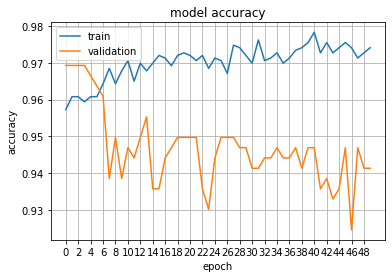

<Figure size 432x288 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.xticks(range(0,50, 2))
plt.grid()
plt.show()
plt.savefig(path + "/accuracy.png")

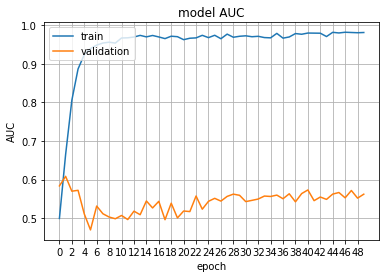

<Figure size 432x288 with 0 Axes>

In [37]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.xticks(range(0,50, 2))
plt.grid()
plt.show()
plt.savefig(path + "/auc.png")

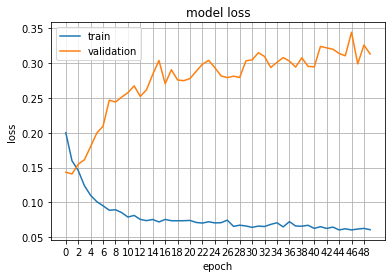

<Figure size 432x288 with 0 Axes>

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.xticks(range(0,50, 2))
plt.grid()
plt.show()
plt.savefig(path + "/loss.png")

## Final Model

In [39]:
optimal_epoch = 12
final_model.fit([X_train_player, X_train_event], y_train, epochs=optimal_epoch, validation_split=0.2)

Epoch 1/12
45/45 [==============================] - 0s 4ms/step - loss: 0.0600 - binary_accuracy: 0.9755 - auc: 0.9823 - val_loss: 0.3007 - val_binary_accuracy: 0.9441 - val_auc: 0.5693
Epoch 2/12
45/45 [==============================] - 0s 3ms/step - loss: 0.0594 - binary_accuracy: 0.9741 - auc: 0.9836 - val_loss: 0.3456 - val_binary_accuracy: 0.9274 - val_auc: 0.5582
Epoch 3/12
45/45 [==============================] - 0s 3ms/step - loss: 0.0617 - binary_accuracy: 0.9741 - auc: 0.9810 - val_loss: 0.3207 - val_binary_accuracy: 0.9413 - val_auc: 0.5625
Epoch 4/12
45/45 [==============================] - 0s 3ms/step - loss: 0.0574 - binary_accuracy: 0.9741 - auc: 0.9844 - val_loss: 0.3160 - val_binary_accuracy: 0.9441 - val_auc: 0.5621
Epoch 5/12
45/45 [==============================] - 0s 3ms/step - loss: 0.0570 - binary_accuracy: 0.9790 - auc: 0.9845 - val_loss: 0.3247 - val_binary_accuracy: 0.9385 - val_auc: 0.5646
Epoch 6/12
45/45 [==============================] - 0s 3ms/step - loss

In [40]:
loss, accuracy, auc = final_model.evaluate([X_test_player, X_test_event], y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.4456 - binary_accuracy: 0.8945 - auc: 0.5503


In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [42]:
pred = final_model.predict([X_test_player, X_test_event])
pred = (pred >= 0.5).astype('uint8')

In [43]:
cm = confusion_matrix(y_test, pred)
cm

array([[176,  14],
       [  7,   2]], dtype=int64)

In [44]:
roc_auc_score(y_test, pred)

0.5742690058479533

## Player Embeddings

In [45]:
# run or load
# embs = final_model.layers[1].get_weights()[0]
# pickle.dump(embs, open("embs.p", "wb"))

embs = pickle.load(open("embs.p", "rb"))

In [46]:
embs.shape

(126, 20)

In [47]:
from sklearn.metrics.pairwise import cosine_similarity

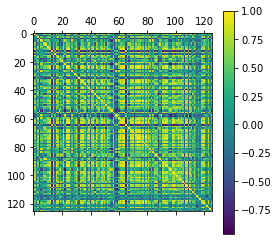

In [48]:
cos_sim = cosine_similarity(embs)
plt.matshow(cos_sim)
plt.colorbar()
plt.show()

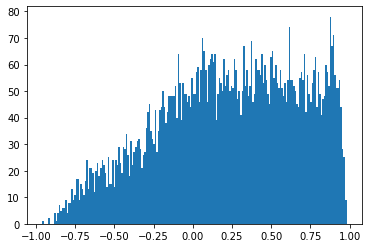

In [49]:
upp_tri = np.triu_indices(cos_sim.shape[0], 1)
plt.hist(cos_sim[upp_tri], bins=200)
plt.show()

In [50]:
def get_player_with_affinity(affinity, cos_sim, threshold):
    """Get a player pair within +/- threshold of the given affinity.
    If more than one pair, randomly selects a pair."""
    upp_tri_indx = np.triu_indices(cos_sim.shape[0], 1)
    upp_tri = cos_sim[upp_tri_indx]
    
    if isinstance(affinity, float):
        all_indx = np.where((upp_tri < affinity + threshold) & (upp_tri > affinity - threshold))[0]
        indx = random.choice(all_indx)
    elif affinity == "max":
        indx = np.argmax(upp_tri)
    elif affinity == "min":
        indx = np.argmin(upp_tri)
    else:
        return "Invalid affinity value. Input a float or 'min', 'max'"

    p1 = load.Player.unique()[upp_tri_indx[0][indx]]
    p2 = load.Player.unique()[upp_tri_indx[1][indx]]
    t1 = load.Team[load.Player == p1].unique()[0]
    t2 = load.Team[load.Player == p2].unique()[0]
    print("{} ({}) & {} ({}) has affinity {}".format(p1, t1, p2, t2, upp_tri[indx]))

In [51]:
get_player_with_affinity(0.9, cos_sim, 0.01)

Kristin Lewicki (Buffalo Beauts) & Cassidy MacPherson (Buffalo Beauts) has affinity 0.8903419971466064


In [52]:
def get_affinity(player_1, player_2, cos_sim):
    """Returns the cosine similarity between the vector embeddings
    of <player_1> and <player_2>.
    
    Arguments:
    player_1, player_2 -- names of player 1 and 2
    cos_sim -- cosine similarity matrix
    """
    id_1 = np.where(load.Player.unique() == player_1)[0][0]
    id_2 = np.where(load.Player.unique() == player_2)[0][0]
    
    return cos_sim[id_1, id_2]

In [53]:
# affinity of specific pair
get_affinity('Kaleigh Fratkin', 'Mallory Souliotis', cos_sim)

0.08814804